This notebook lays out the model training process for ConvLSTM, including loading the data, hyperparameter setting, and customizing the loss function.

The ConvLSTM implementation is from [GeoTorchAI](https://kanchanchy.github.io/geotorchai/index.html) for experimentation. The code for training the ConvLSTM is adapted from [here](https://kanchanchy.github.io/geotorchai/coding_examples.html). See [here](https://kanchanchy.github.io/geotorchai/installation.html) for instructions on how to install GeoTorchAI.

In [1]:
import os
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from geotorchai.models.grid import ConvLSTM

import matplotlib.pyplot as plt

# autoreload modules when code is changed
%load_ext autoreload
%autoreload 2

# load ImageFolder.py from scripts folder
import sys
sys.path.append('../scripts/')
from ImageFolder import ImageFolder, ImageDataset
from LossFunctions import SSIMLoss

## Initialize device with GPU
In order to perform deep learning with GPU, we need to check whether GPU is available at first. We will initialize the device with GPU if it is available. Otherwise, CPU will be used as the default device.

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

device = get_device()
print(device)

mps


## Define method for calculating three types of errors: MSE, MAE, RMSE

In [3]:
def compute_errors(preds, y_true):
    pred_mean = preds[:, 0:2]
    diff = y_true - pred_mean

    mse = np.mean(diff ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(diff))

    return mse, mae, rmse             

## Define method for calculating validation loss

In [4]:
def get_validation_loss(model, val_generator, criterion, device):
    model.eval()
    mean_loss = []
    for i, sample in enumerate(val_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        mse=criterion(outputs, Y_batch).item()
        mean_loss.append(mse)

    mean_loss = np.mean(mean_loss)
    return mean_loss

## Define model class

In [5]:
class GeoTorchConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers):
        super().__init__()
        self.lstm = ConvLSTM(input_dim=input_size, 
                             hidden_dim=hidden_dim, 
                             num_layers=num_layers)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        return lstm_out

## Initialize parameters

In [6]:
# model parameters
input_dim = 1
input_width = 128
input_height = 128
hidden_layer_sizes = [256, 256, 2]
num_layers = len(hidden_layer_sizes)

# sequence lengths
len_history = 5
len_predict = 1

# training parameters
epoch_nums = 10
learning_rate = 0.0002
batch_size = 32
params = {'batch_size': batch_size, 'shuffle': False, 'drop_last':False, 'num_workers': 2}

# Sets the model output directory
checkpoint_dir = '../models'
model_name = 'convlstm'
model_dir = checkpoint_dir + "/" + model_name
os.makedirs(model_dir, exist_ok=True)

# For loading pretrained model if available
initial_checkpoint = model_dir + '/model.best.pth'
LOAD_INITIAL = False

## Load Data

In [7]:
# Set data paths
data_root = '../data/Processed Dataset/v2 (uses the new segmentation masks)/FutureGAN_format'
train_path = os.path.join(data_root, "train")
test_path = os.path.join(data_root, "test")
val_path = os.path.join(data_root, "val")

In [8]:
train = ImageFolder(root=train_path, transform=transforms.ToTensor())
test = ImageFolder(root=test_path, transform=transforms.ToTensor())
val = ImageFolder(root=val_path, transform=transforms.ToTensor())

train.set_sequential_representation(history_length=len_history, predict_length=len_predict)
test.set_sequential_representation(history_length=len_history, predict_length=len_predict)
val.set_sequential_representation(history_length=len_history, predict_length=len_predict)

train_generator = DataLoader(ImageDataset(train), **params)
test_generator = DataLoader(ImageDataset(test), **params)
val_generator = DataLoader(ImageDataset(val), **params)

In [9]:
train.__getitem__(0).shape

torch.Size([1, 128, 128])

## Define method for initializing model and perform training and testing

In [10]:
def createModelAndTrain(loss_fn):
    device = get_device()

    model = GeoTorchConvLSTM(input_dim, hidden_layer_sizes, num_layers)

    if LOAD_INITIAL:
        model.load_state_dict(torch.load(initial_checkpoint, map_location=lambda storage, loc: storage))

    loss_fn = loss_fn
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    loss_fn.to(device)

    min_val_loss = None
    for e in range(epoch_nums):
        for i, sample in enumerate(train_generator):
            X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
            Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = loss_fn(outputs[:, len_history - 1:len_history, :, :, :], Y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = get_validation_loss(model, val_generator, loss_fn, device)
        
        print('Epoch [{}/{}], Train Loss: {:.4f}'.format(e + 1, epoch_nums, loss.item()), 'Mean Val Loss:', val_loss)

        if min_val_loss == None or val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), initial_checkpoint)
            print('best model saved!')

    model.load_state_dict(torch.load(initial_checkpoint, map_location=lambda storage, loc: storage))
    model.eval()
    rmse_list = []
    mse_list = []
    mae_list = []
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        mse, mae, rmse = compute_errors(outputs[:, len_history - 1:len_history, :, :, :].cpu().data.numpy(),
                                        Y_batch.cpu().data.numpy())

        rmse_list.append(rmse)
        mse_list.append(mse)
        mae_list.append(mae)

    rmse = np.mean(rmse_list)
    mse = np.mean(mse_list)
    mae = np.mean(mae_list)

    print("\n************************")
    print("Test ConvLSTM model with Crack Dataset:")
    print('Test mse: %.6f mae: %.6f rmse (norm): %.6f' % (
    mse, mae, rmse))

## Define loss functions

In [11]:
# Set loss functions
loss_mse = nn.MSELoss()
loss_ssim = SSIMLoss()

## Call model training and testing from main

In [12]:
if __name__ == '__main__':
    try:
        createModelAndTrain(loss_fn=loss_mse)
        # createModelAndTrain(loss_fn=loss_ssim)
    finally:
        # Clear the memory
        torch.cuda.empty_cache()

/Users/jenny/miniconda3/envs/crack/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1, 128, 128])) that is different to the input size (torch.Size([32, 1, 2, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jenny/miniconda3/envs/crack/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15, 1, 1, 128, 128])) that is different to the input size (torch.Size([15, 1, 2, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jenny/miniconda3/envs/crack/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9, 1, 1, 128, 128])) that is different to the input size (torch.Siz

Epoch [1/10], Train Loss: 0.0100 Mean Val Loss: 0.01681573875248432
best model saved!
Epoch [2/10], Train Loss: 0.0099 Mean Val Loss: 0.016461389139294624
best model saved!
Epoch [3/10], Train Loss: 0.0092 Mean Val Loss: 0.0158647783100605
best model saved!
Epoch [4/10], Train Loss: 0.0078 Mean Val Loss: 0.01471592579036951
best model saved!
Epoch [5/10], Train Loss: 0.0081 Mean Val Loss: 0.014255145564675331
best model saved!
Epoch [6/10], Train Loss: 0.0075 Mean Val Loss: 0.01429776381701231
Epoch [7/10], Train Loss: 0.0073 Mean Val Loss: 0.01457503903657198
Epoch [8/10], Train Loss: 0.0075 Mean Val Loss: 0.014562355354428291
Epoch [9/10], Train Loss: 0.0073 Mean Val Loss: 0.014254461973905563
best model saved!
Epoch [10/10], Train Loss: 0.0072 Mean Val Loss: 0.013958443887531757
best model saved!

************************
Test ConvLSTM model with Crack Dataset:
Test mse: 0.010764 mae: 0.029960 rmse (norm): 0.103748


# Visualize Predictions

In [16]:
# Load model from checkpoint file in models folder
model = GeoTorchConvLSTM(input_dim, hidden_layer_sizes, num_layers)
model.load_state_dict(torch.load(initial_checkpoint))
model.to(device)

GeoTorchConvLSTM(
  (lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): _ConvLSTMCell(
        (conv): Conv2d(257, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (1): _ConvLSTMCell(
        (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (2): _ConvLSTMCell(
        (conv): Conv2d(258, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
  )
)

In [17]:
# Write a function to use plt to show the model predictions
def show_predictions(model, test_generator, device, num_samples=5):
    model.eval()
    for i, sample in enumerate(test_generator):
        X_batch = sample["X_data"].type(torch.FloatTensor).to(device)
        Y_batch = sample["Y_data"].type(torch.FloatTensor).to(device)

        outputs = model(X_batch)
        break

    for i in range(num_samples):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(outputs[i, len_history - 1, 0, :, :].cpu().data.numpy(), cmap='gray')
        plt.title("Predicted")
        plt.subplot(1, 2, 2)
        plt.imshow(np.squeeze(Y_batch[i, 0, :, :].cpu().data.numpy()), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        plt.show()

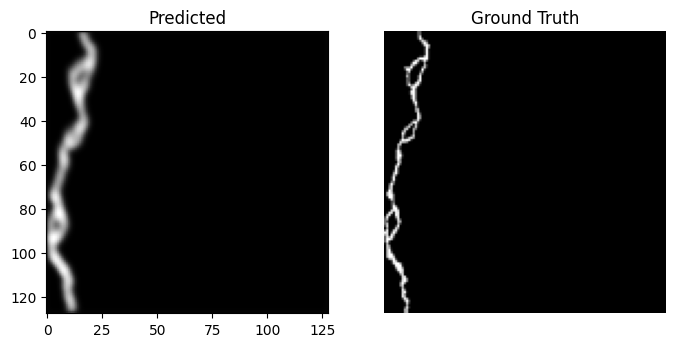

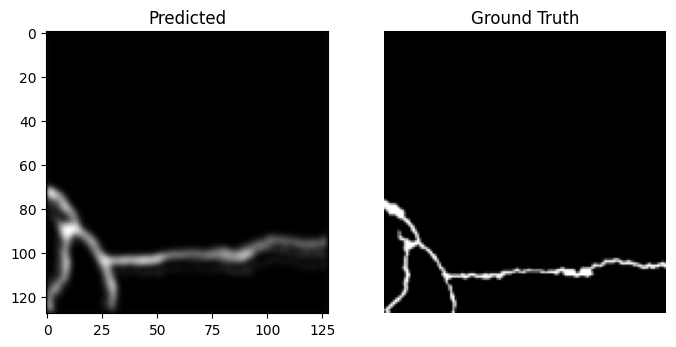

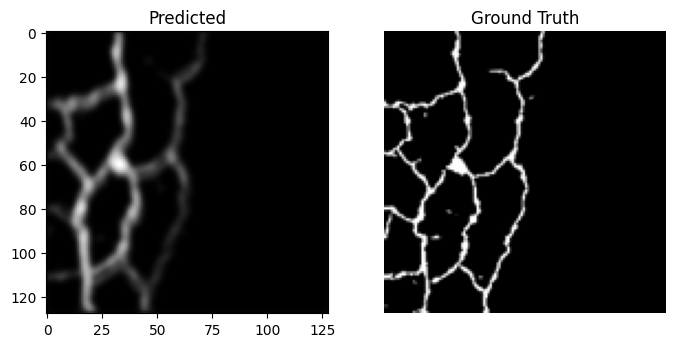

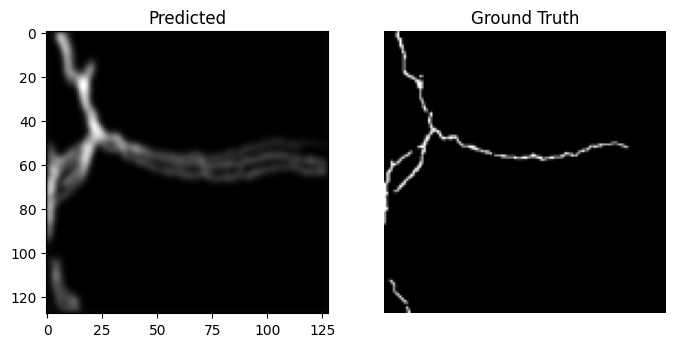

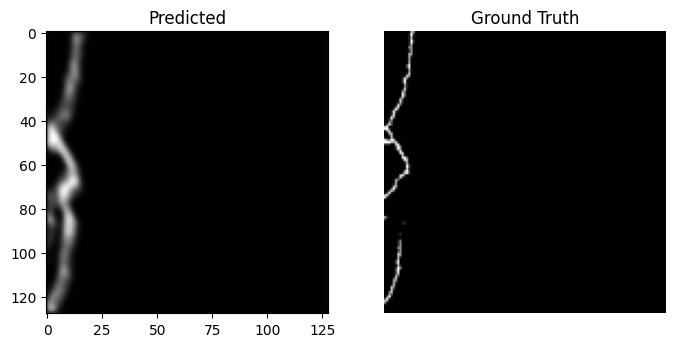

In [18]:
show_predictions(model, test_generator, device, num_samples=5)